In [1]:
import numpy as np
import pandas as pd
import pyreadr
import datetime
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS

In [2]:
# define paths
data_path = '/Users/simonneumeyer/Dropbox/Ethiopia IE - Road Safety/Data/'
crashes_path = 'ETRE - Crashes/'
crash_file = 'FinalData/crashes.csv'
traffic_path = 'ETRE - Traffic/'
traffic_file = 'FinalData/traffic.pq'
precipitation_path = 'Precipitation/'
precipitation_file = 'FinalData/precipitation.csv'

In [3]:
segment_time = pd.read_parquet(data_path + 'Time Segment Data/segment_time_panel.pq', engine='pyarrow')

## Regression:

In [4]:
# OLS model:

# dropping NAs where we don't have speed_mean
df = segment_time.dropna(subset=['speed_mean']).reset_index()
y = df.accidents

cols = ['traffic', 'precip_mm', 'weekend', 
        'holiday', 'holiday_plusminus_2day', 'speed_mean'] # speed_mean excluded because of NAs
X = df[cols]
X = sm.add_constant(X)

# for clustered se option
groups = df.km_from_addis

# Fit and summarize OLS model
model = sm.OLS(y, X)

linreg = model.fit()
#linreg = model.fit(cov_type='cluster', cov_kwds={'groups': groups})

print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:              accidents   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     26.90
Date:                Mon, 10 May 2021   Prob (F-statistic):           3.00e-32
Time:                        03:48:04   Log-Likelihood:             4.2475e+06
No. Observations:             1963560   AIC:                        -8.495e+06
Df Residuals:                 1963553   BIC:                        -8.495e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

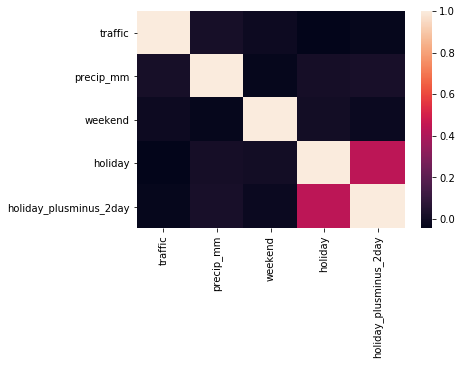

In [11]:
# check for correlation between covariates:
corr = np.corrcoef(X.T[1:])
sns.heatmap(corr, xticklabels=X.columns[1:], yticklabels=X.columns[1:])
plt.show()

In [7]:
# Fixed Effects Model:

df = segment_time.set_index(['km_from_addis', 'date']).sort_index()

y = df.accidents

cols = ['traffic', 'precip_mm', 'weekend', 
        'holiday', 'holiday_plusminus_2day'] # speed_mean excluded because of NAs
X = df[cols]
X = sm.add_constant(X)

mod = PanelOLS(y, X, entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:              accidents   R-squared:                     3.086e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.1623
No. Observations:             1966246   R-squared (Within):            3.086e-05
Date:                Mon, May 10 2021   R-squared (Overall):          -3.431e-05
Time:                        03:48:18   Log-likelihood                 4.255e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.134
Entities:                          79   P-value                           0.0000
Avg Obs:                    2.489e+04   Distribution:               F(5,1966162)
Min Obs:                    2.489e+04                                           
Max Obs:                     2.49e+04   F-statistic (robust):             3.9223
                            